In [ ]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()
Pkg.status()

In [13]:
using ModelingToolkit
using DifferentialEquations
#using Interpolations
using PhysicsInformedRegression

# Lotka-Volterra model for predator-prey dynamics
The Lotka-Volterra equations describe the dynamics of predator-prey interactions in an ecosystem. The model consists of two differential equations that represent the growth of prey and the growth of predators based on the availability of prey.

$$
\begin{align*}
\frac{dx}{dt} &= \alpha x - \beta xy \\
\frac{dy}{dt} &= \delta xy - \gamma y
\end{align*}
$$

Where: 
- $x$ is the prey population (e.g., rabbits)
- $y$ is the predator population (e.g., foxes)
- $\alpha$ is the growth rate of prey
- $\beta$ is the rate of predation (how many prey are consumed by predators)
- $\delta$ is the growth rate of predators per prey consumed
- $\gamma$ is the natural death rate of predators


## Model setup in Julia
In julia we choose to use the ([DifferentialEquations.jl](https://diffeq.sciml.ai/stable/) package) to represent the Lotka-Volterra model. The following defined the symbolic parameters and the system of equations.

In [14]:

## LOTKA VOLTERA
@parameters α β γ δ
@independent_variables t
@variables x(t) y(t)
D = Differential(t)
eqs = [D(x) ~ α*x - β*x*y,
    D(y) ~ -γ*y + δ*x*y]


# Define the system
@named sys = ODESystem(eqs, t)
sys = complete(sys)

Model sys:
Equations (2):
  2 standard: see equations(sys)
Unknowns (2): see unknowns(sys)
  x(t)
  y(t)
Parameters (4): see parameters(sys)
  α
  β
  δ
  γ

# Simulation setup
We choose the following parameters for the simulation:

* $\alpha = 1.5$  # Growth rate of prey
* $\beta = 1.0$  # Rate of predation
* $\delta = 3.0$  # Growth rate of predators per prey consumed
* $\gamma = 1.0$  # Natural death rate of predators

aswell as the initial conditions:
* $x_0 = 1,0$  # Initial prey population
* $y_0 = 0.5$  # Initial predator population

And simulate the system over a time span of $t = 0$ to $t = 10$ with $1000$ uniform time steps.


In [21]:
# Define the initial conditions and parameters
u0 = [x => 1.0,
    y => 1.0]

p = Dict([α => 1.5,
    β => 1.0,
    γ => 3.0,
    δ => 1.0])

# Define the time span
start = 0; stop = 10; len = 1000 
timesteps = collect(range(start, stop, length = len))

# Simulate the system
prob = ODEProblem(sys, u0,(timesteps[1], timesteps[end]) ,p, saveat = timesteps)
sol = solve(prob)

# Compute the derivatives
du_approx =  PhysicsInformedRegression.finite_diff(sol.u, sol.t)


1000-element Vector{Vector{Float64}}:
 [0.5112381874128863, -1.9776228698845326]
 [0.5224347641758899, -1.9555359683624036]
 [0.544770299222013, -1.9117934089157502]
 [0.5669969939682518, -1.8689078709411246]
 [0.5891276417343844, -1.8268684229921368]
 [0.6111750358401781, -1.785664133622359]
 [0.6331519696053888, -1.7452840713853681]
 [0.6550710266821459, -1.7057172462236139]
 [0.6769409146883476, -1.6669513295157519]
 [0.6987740399494595, -1.6289742728844967]
 ⋮
 [0.43413777175317, -2.134698389544061]
 [0.4570762935001725, -2.087499384071721]
 [0.47983278403044965, -2.041199272566464]
 [0.5024271225754754, -1.9957983798960703]
 [0.5248791883666846, -1.9512970309281146]
 [0.5472088606354291, -1.9076955505300102]
 [0.5694360186130439, -1.8649942635691983]
 [0.5915805415311196, -1.8231934949136859]
 [0.6026346291292353, -1.802518280770791]

In [16]:
paramsest = PhysicsInformedRegression.physics_informed_regression(sys, sol.u, du_approx)

#compare the estimated parameters to the true parameters
parameterdict = Dict(p)
for (i, param) in enumerate(parameters(sys))
    println("Parameter $(param) = $(parameterdict[param]) estimated as $(paramsest[param])")
end

Parameter α = 1.5 estimated as 1.498978644512317
Parameter β = 1.0 estimated as 0.9991910254495253
Parameter δ = 1.0 estimated as 0.99937640189985
Parameter γ = 3.0 estimated as 2.999430028234546


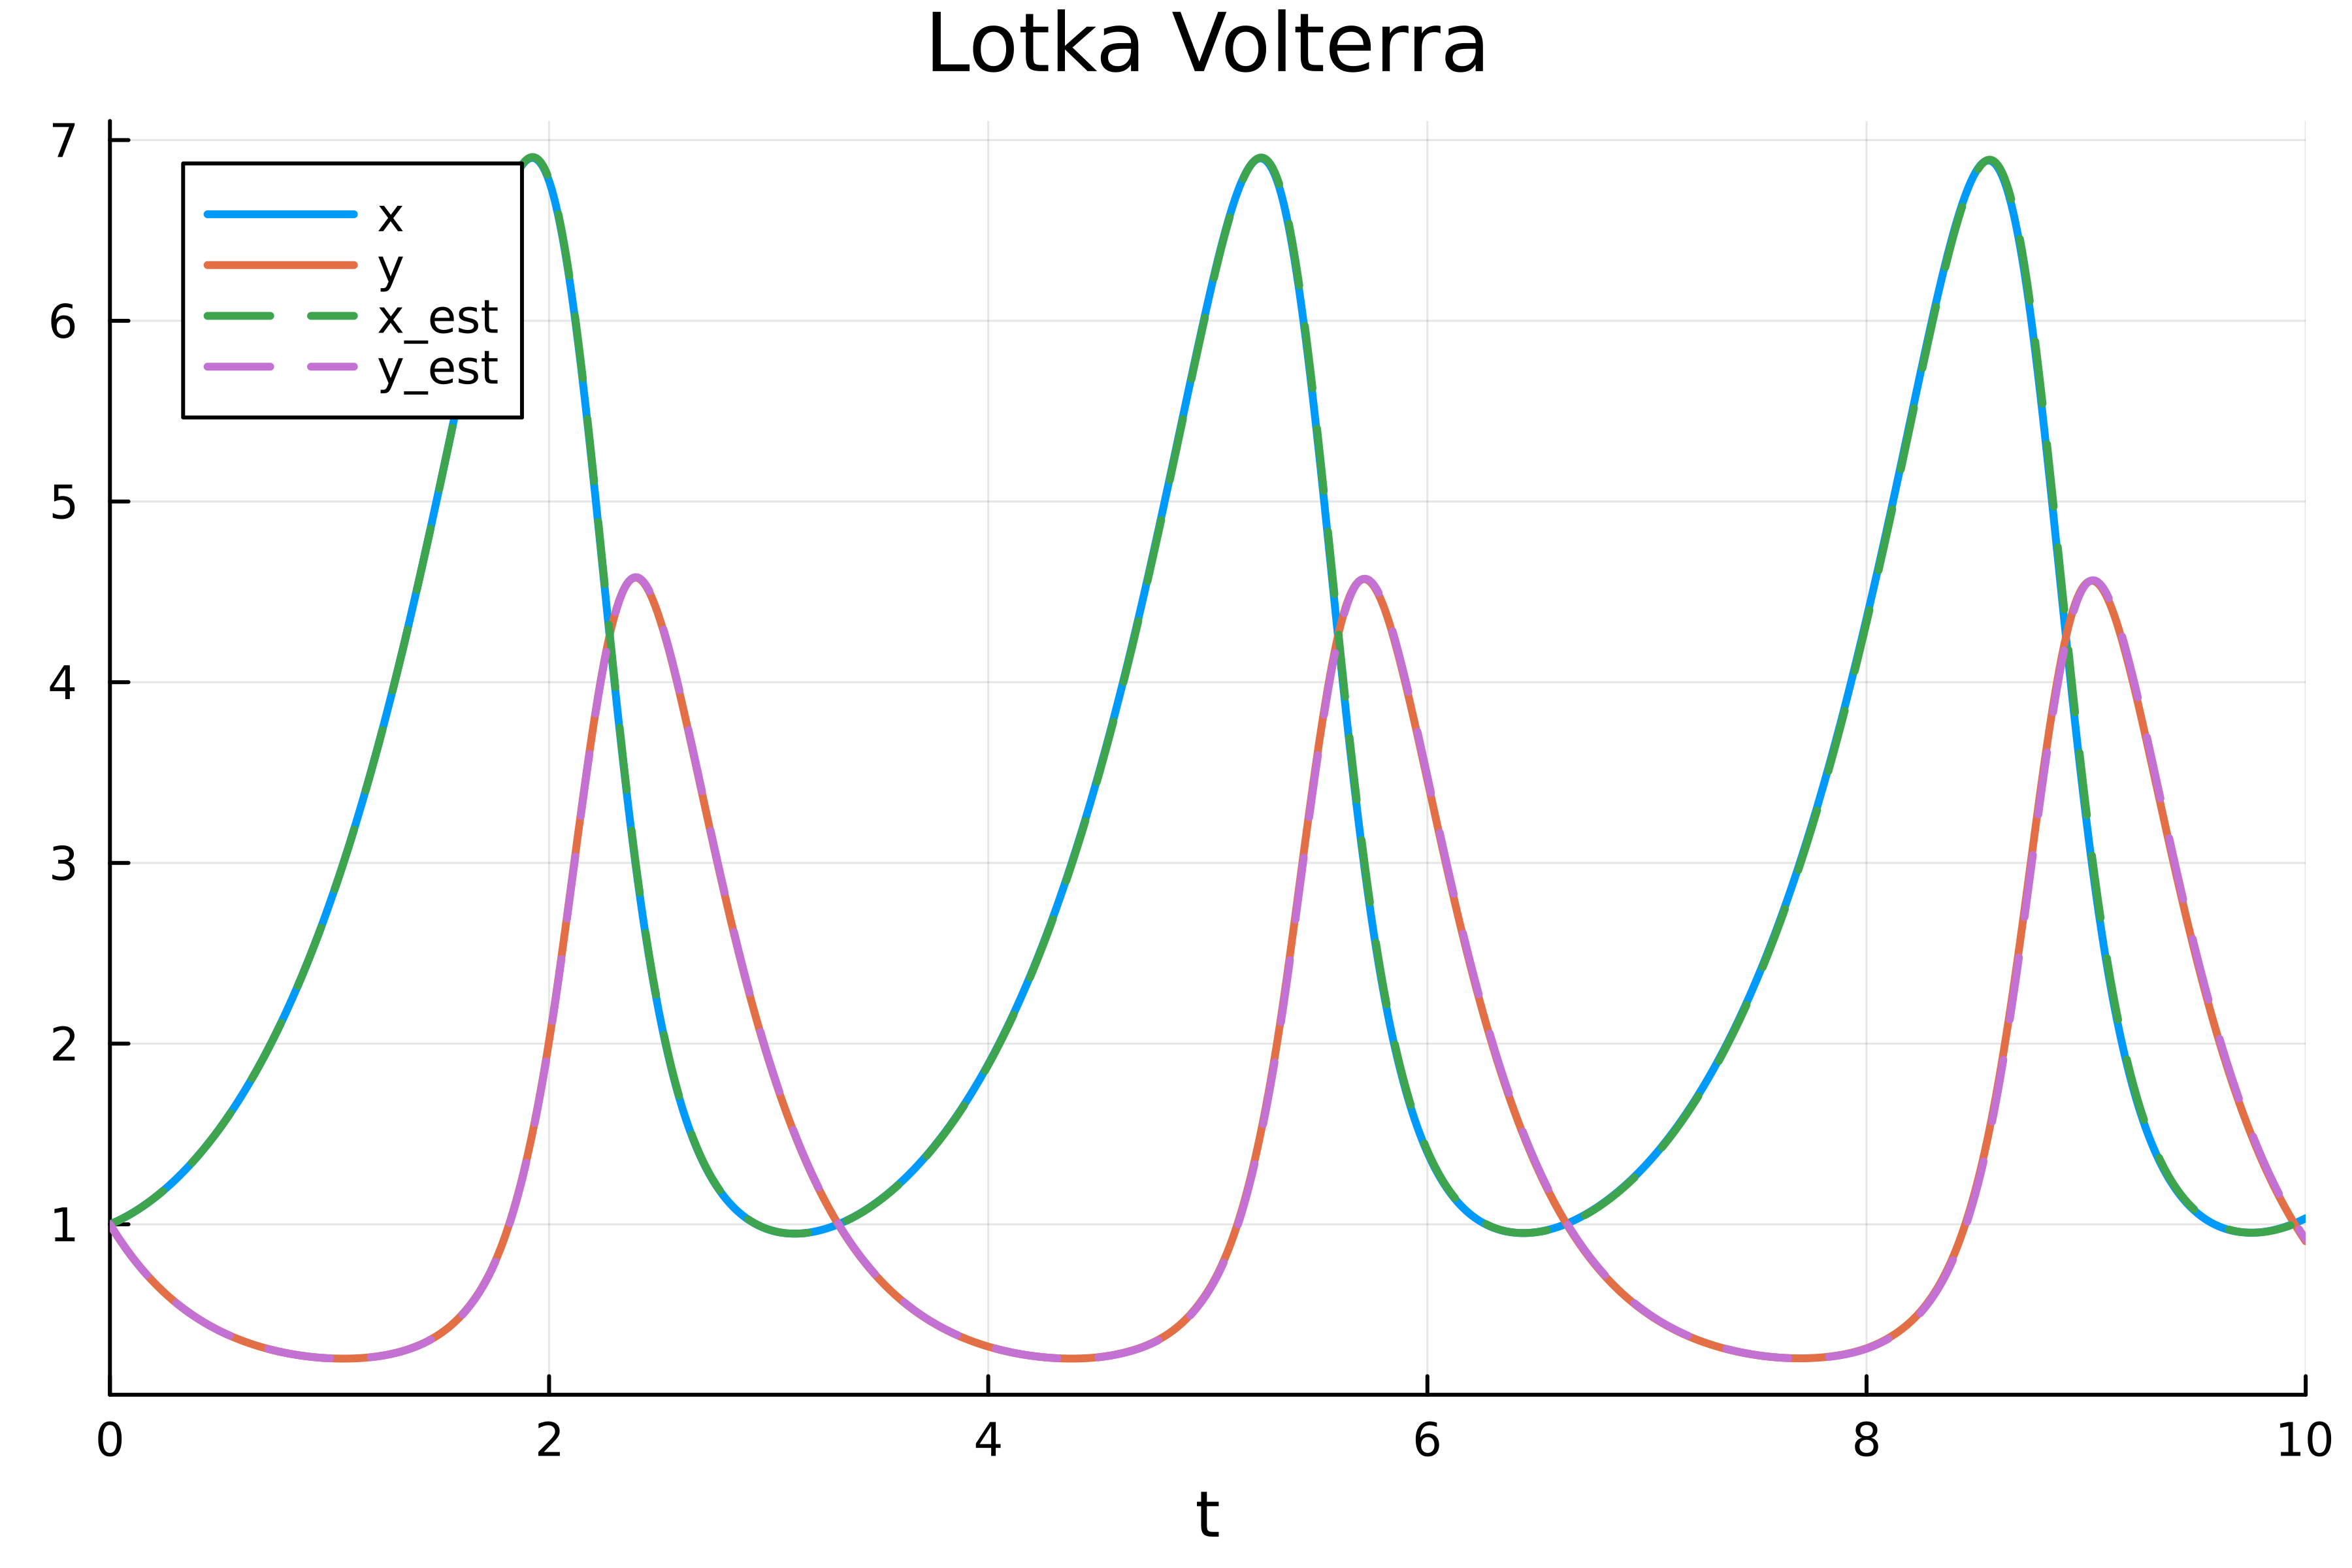

In [30]:
# Plot the results
using Plots
estimated_sol = solve(ODEProblem(sys, u0,(start, stop) ,paramsest), Tsit5(), saveat = timesteps)
plot(sol, label = ["x" "y"], title = "Lotka Volterra", lw = 2, dpi = 600)
plot!(estimated_sol, label = ["x_est" "y_est"], lw = 2, ls = :dash, dpi = 600)
# Save the plot
# savefig("../plots/lotka_volterra.png")

# Evaluating the results
The regression is run once again for different numbers of collocation points, and the results are compared to the original parameters. The goal is to see how the number of collocation points affects the accuracy of the recovery. The results are expected to show that as the number of collocation points increases, the accuracy of the recovery improves. 


In [19]:
using Random
Random.seed!(1234) # Set seed for reproducibility
include("../utils/julia_utils.jl")
export create_table, noise_v_collocation_points

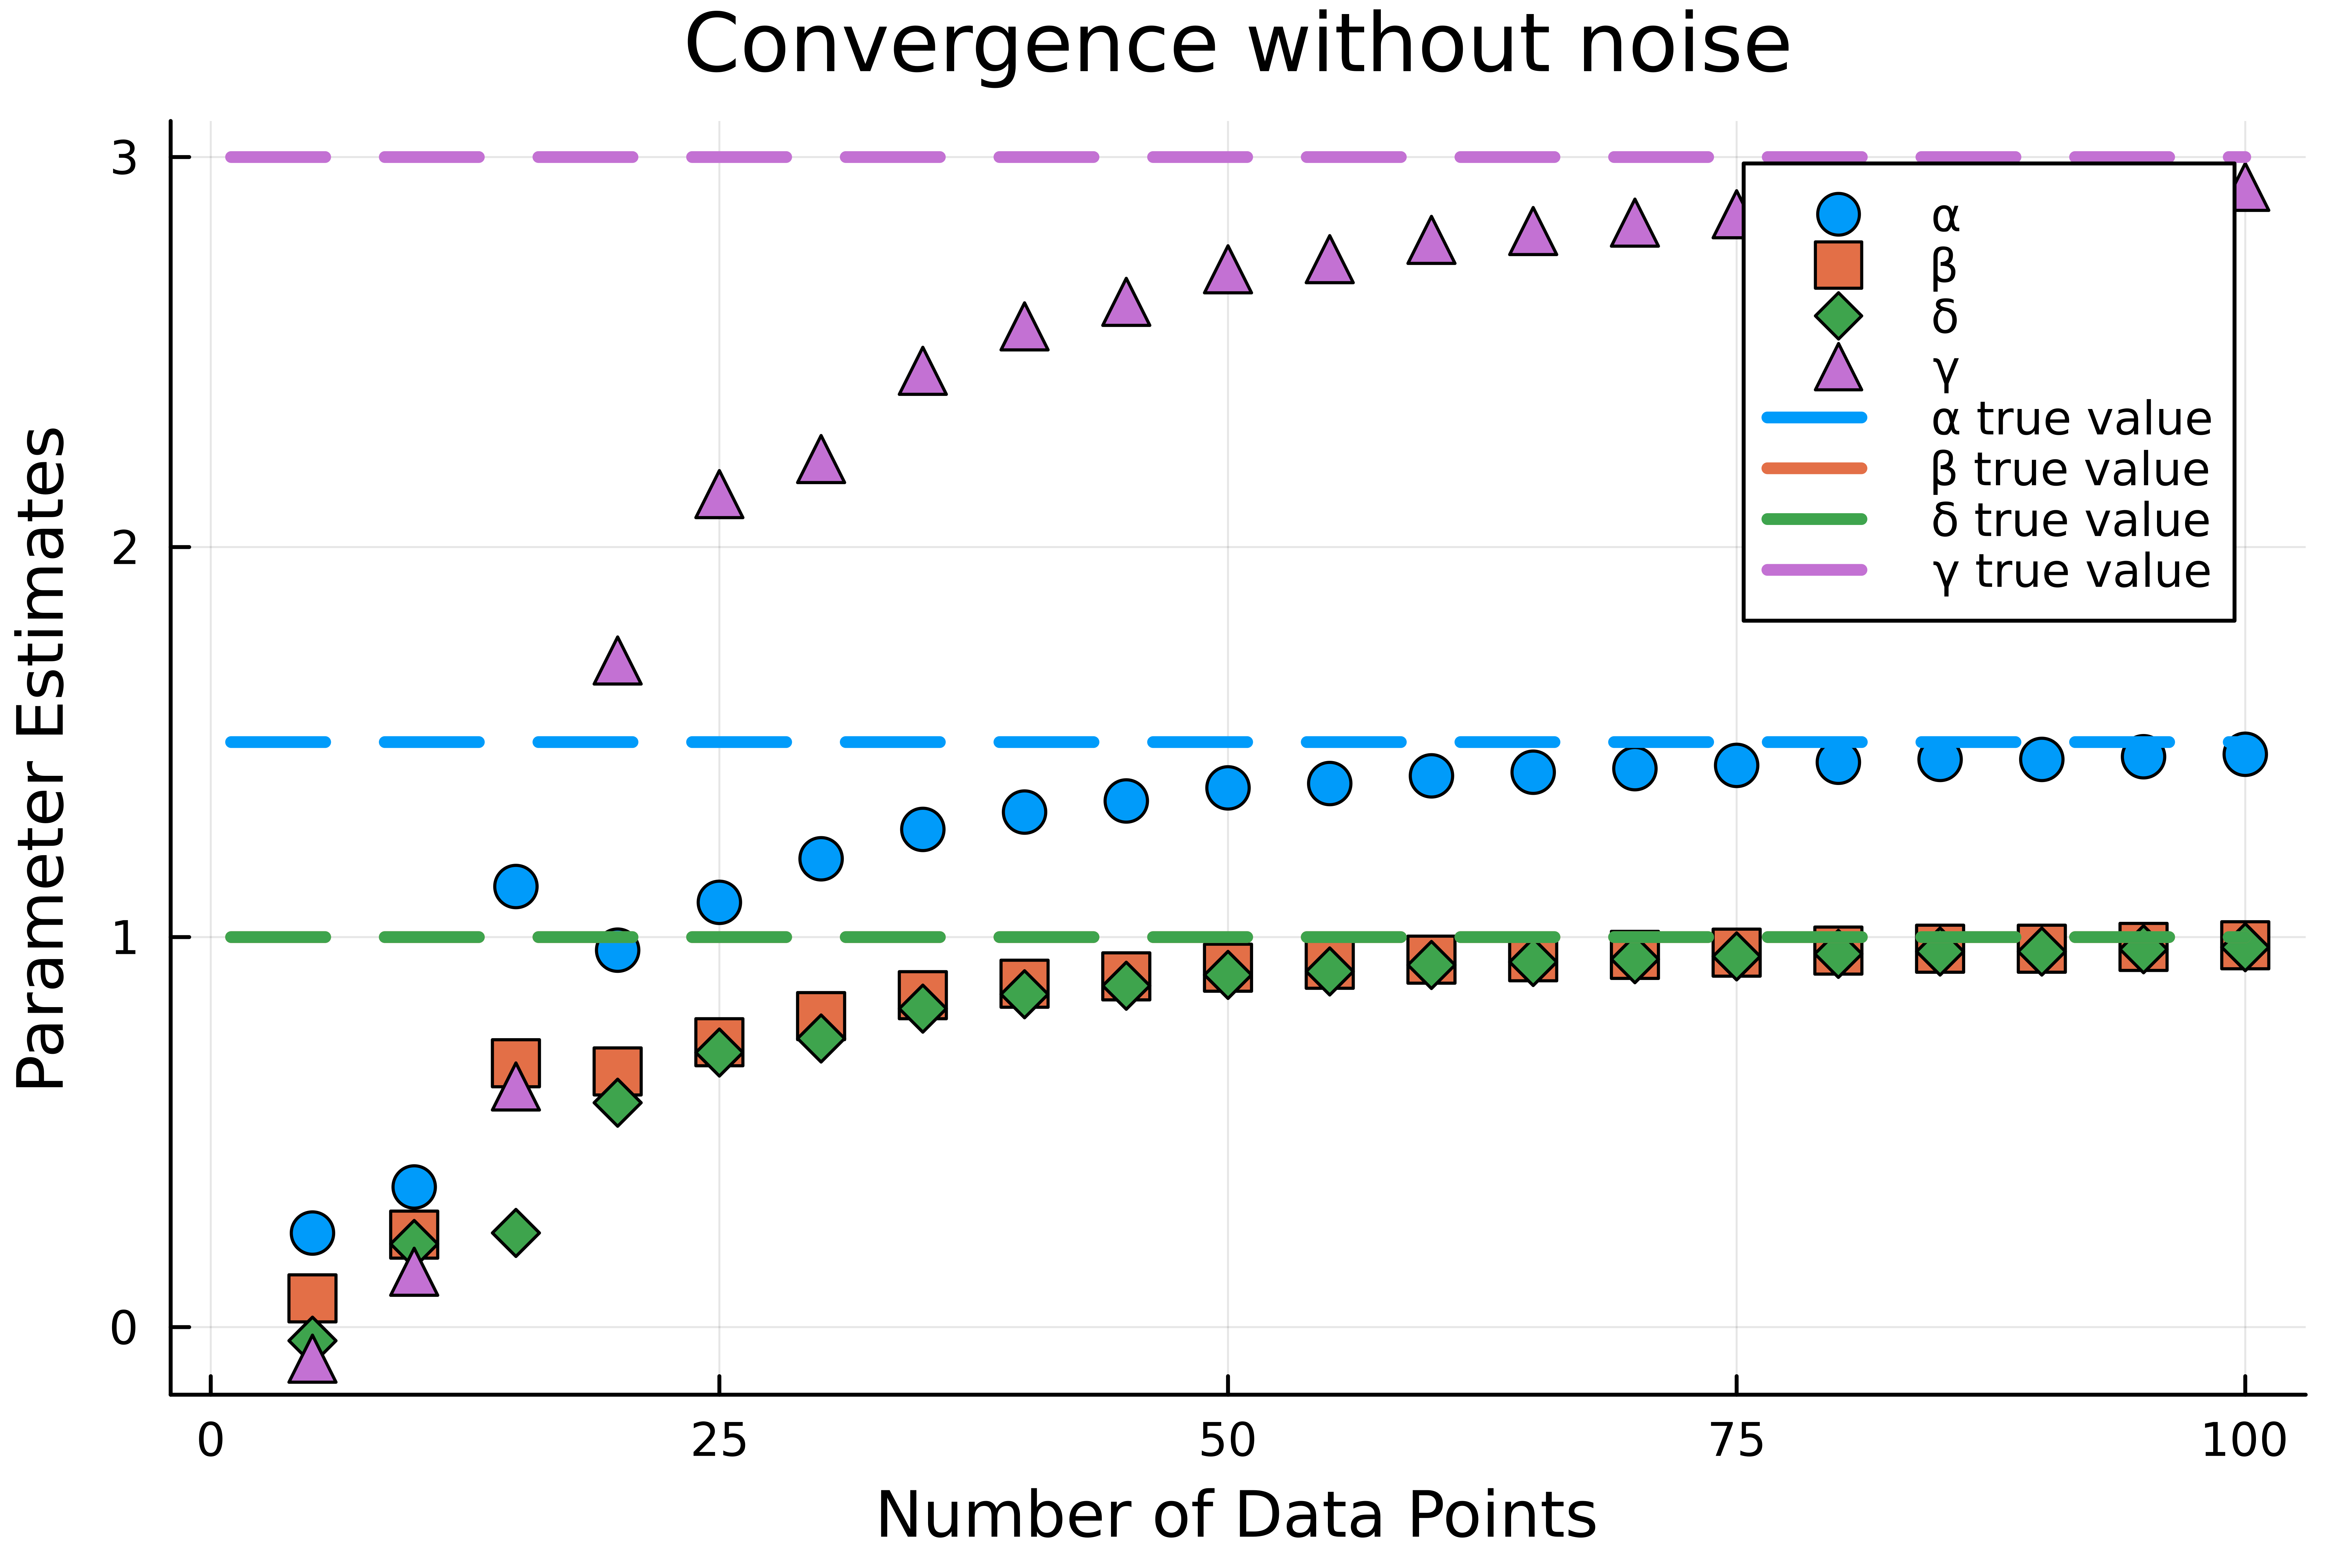

In [22]:
noise_vals = [0.0]
n_data_points = collect(5:5:100)
n_iter = 20
parameter_estimates = noise_v_collocation_points(sys, sol, noise_vals, n_data_points; n_iter)

#parameter convergence without noise
marker_shapes = [:circle, :square, :diamond, :utriangle]
p1 = plot()
parameter_names = [string(param) for param in parameters(sys)]
x_values = collect(first.(keys(parameter_estimates)))
parameter_values = hcat([collect(values(parameter_estimates[n_data_points, 0.0])) for n_data_points in x_values]...)
scatter!(p1, x_values, parameter_values', label = hcat(parameter_names...), xlabel = "Number of Data Points", ylabel = "Parameter Estimates",
     title = "Convergence without noise", lw = 2, dpi = 1200, markershape = hcat(marker_shapes...), markersize = 6, legend = :topright)
#plot horizontal lines for true parameter values
for (i, param) in enumerate(parameters(sys))
    plot!(p1, [1, maximum(n_data_points)], repeat([p[param]], 2), label = "$(param) true value", ls = :dash, lw = 3, color = i)
end
savefig("../plots/Lotka_volterra_convergence.png")
display(p1)

The convergence of the parameters is evaluated once again, but for different numbers of collocation points and noise levels. The results are expected to show that as the number of collocation points increases, the accuracy of the recovery improves, and the noise level has a significant impact on the accuracy of the recovery.

In [23]:
#
noise_vals = [0.0, 0.01, 0.05, 0.1]
n_data_points = [10, 50, 100, 200]
n_iter = 20
parameter_estimates = noise_v_collocation_points(sys, sol, noise_vals, n_data_points; n_iter)

rel_error_ests = copy(parameter_estimates)
#calculate relative errors
for ((n_data_points, noise_val), estimates) in parameter_estimates
    rel_error_ests[(n_data_points, noise_val)] = abs.(estimates .- values(p)) ./ abs.(values(p))
end

### $\alpha$ relative error

In [24]:
using DataFrames
α_rel_error_percentage = create_table(rel_error_ests; parameter_idx = 1)


Row,n_data_points,noise_0.0,noise_0.01,noise_0.05,noise_0.1
,Int64,Float64,Float64,Float64,Float64
1,10,76.05,76.18,76.4,75.01
2,50,7.83,7.921,8.766,10.76
3,100,2.085,2.42,4.429,8.531
4,200,0.5628,0.7963,1.653,5.913


### $\beta$ relative error 

In [25]:
β_rel_errors_percentage = create_table(rel_error_ests; parameter_idx = 2)

Row,n_data_points,noise_0.0,noise_0.01,noise_0.05,noise_0.1
,Int64,Float64,Float64,Float64,Float64
1,10,76.29,76.51,75.56,74.17
2,50,7.847,7.881,10.83,18.52
3,100,2.095,2.449,6.377,16.9
4,200,0.5756,0.8392,4.82,13.45


### $\gamma $ relative errors

In [26]:
γ_rel_errors_percentage = create_table(rel_error_ests; parameter_idx = 3)

Row,n_data_points,noise_0.0,noise_0.01,noise_0.05,noise_0.1
,Int64,Float64,Float64,Float64,Float64
1,10,78.68,78.76,75.32,81.12
2,50,9.694,9.621,13.48,23.99
3,100,2.595,2.557,6.368,19.5
4,200,0.6872,0.6927,6.714,19.58


### $\delta $ relative errors

In [27]:
δ_rel_errors_percentage = create_table(rel_error_ests; parameter_idx = 4)

Row,n_data_points,noise_0.0,noise_0.01,noise_0.05,noise_0.1
,Int64,Float64,Float64,Float64,Float64
1,10,95.27,95.32,92.89,96.84
2,50,9.594,9.582,11.58,18.01
3,100,2.546,2.466,4.894,13.27
4,200,0.6436,0.5878,4.249,13.99
